In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)  # reset to matplotlib defaults

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import re

# Nature Medicine style defaults
single_style = "nature_single.mplstyle"
single_style = "nature_single_narrow.mplstyle"
double_style = "nature_double.mplstyle"
third_style = "nature_third.mplstyle"
plt.rcParams["figure.dpi"] = 150

save = False

home_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/'
figures_path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/figures/diet_intervention'

PHENOTYPE = 'Vat' # Triglycerides or Vat or WBC or Ultrasound
SPECIES = 'segal_species' # 'mpa_species' or 'segal_species'
PROBLEM = 'regression'

In [3]:
phenotype_file = None  

if PHENOTYPE == 'Triglycerides':
    phenotype_file = 'diet_intervention_results_queue_foods_only_triglycerides.pkl' 
    individual_example_index = 386
elif PHENOTYPE == 'Vat':
    phenotype_file = 'diet_intervention_results_queue_foods_only_total_scan_vat_mass.pkl'
    individual_example_index = 126
elif PHENOTYPE == 'WBC':
    phenotype_file = 'diet_intervention_results_queue_foods_only_bt__wbc.pkl' 
    individual_example_index = 119

Load Data

In [4]:
phenotypes_mb = pd.read_pickle('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/phenotypes_mb.pkl')

with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/target_phenotypes.pkl', 'rb') as f:
    target_phenotypes = pickle.load(f)

base_features = ['age', 'sex']
flat_targets = sum(target_phenotypes, [])

microbial_features = [col for col in phenotypes_mb.columns if col not in flat_targets + ['RegistrationCode']]

microbial_features_df = phenotypes_mb[microbial_features]
microbial_features_df

,age,sex,Duodenibacillus intestinigallinarum,Duodenibacillus intestinavium,Duodenibacillus massiliensis,Sutterella wadsworthensis,Sutterella sp937923675,Sutterella seckii_A,Sutterella sp934255515,Sutterella wadsworthensis_A,...,Alistipes avistercoris,Alistipes dispar,Tidjanibacter inops,Oxalobacter aliiformigenes,Oxalobacter formigenes,Duodenibacillus sp900544335,Aphodousia faecalis,Parasutterella gallistercoris,Parasutterella excrementihominis,Mesosutterella multiformis
0,0.375867,1.0,9.225612,17.789424,4.065616,2.399299,31.736722,18.595528,5.392739,3.436543,...,7.009843,7.563322,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
1,-1.189224,0.0,9.225612,9.234695,4.065616,3.740498,15.617160,7.637018,5.392739,6.478278,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
2,-0.797952,1.0,9.225612,9.234695,4.065616,2.399299,15.617160,7.637018,5.392739,3.436543,...,7.009843,4.725922,4.652684,10.787403,12.012584,8.688301,10.365971,9.255033,7.956086,6.419551
3,-0.276254,1.0,9.225612,9.234695,4.065616,4.145110,15.617160,7.637018,5.392739,3.436543,...,7.009843,5.927581,4.652684,8.667175,12.012584,8.688301,10.365971,9.255033,4.595218,6.419551
4,1.549686,1.0,9.225612,9.234695,4.065616,2.399299,15.617160,7.637018,5.392739,3.436543,...,7.009843,4.725922,8.111075,6.635850,12.012584,8.688301,10.365971,9.255033,9.010128,10.112833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10059,0.245443,0.0,9.225612,9.234695,4.065616,2.399299,15.617160,7.637018,5.392739,6.249221,...,7.009843,5.763687,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.834536,6.419551
10060,-0.015406,1.0,9.225612,9.234695,4.065616,4.769400,15.617160,7.637018,5.392739,6.676083,...,7.009843,8.242829,6.564945,6.635850,12.012584,8.688301,10.365971,9.255033,5.494743,6.419551
10061,0.767140,0.0,9.225612,9.234695,5.963985,2.527101,36.631689,13.785521,9.313321,4.697424,...,7.009843,4.725922,4.652684,6.635850,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551
10062,-1.319649,1.0,10.307204,9.234695,7.791315,2.399299,15.617160,7.637018,5.392739,3.436543,...,7.009843,4.725922,4.652684,9.536412,12.012584,8.688301,10.365971,9.255033,4.138850,6.419551


In [5]:
species = '' if SPECIES == 'segal_species' else '_mpa'

diet_mb = pd.read_pickle(home_path + f"data/{SPECIES}/diet_mb.pkl")
with open(home_path + f'data/{SPECIES}/my_lists.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
base_features, all_features, targets = loaded_lists

# all_features_formatted = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in all_features]
all_features_formatted = all_features

with open(home_path + f'data/{SPECIES}/scaler.pkl', 'rb') as scaler_file:
        scaler = pickle.load(scaler_file)

# Filter non significant correlations from the permutations
with open(f'/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/{PROBLEM}/{SPECIES}/significant_targets.pkl', 'rb') as file:
    loaded_lists = pickle.load(file)
significant_targets = loaded_lists
significant_targets_indices = [targets.index(item) for item in significant_targets]

with open('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/food_shortnames.pkl', 'rb') as file:
    food_shortnames = pickle.load(file)
food_shortnames_formatted = [re.sub(r'[^a-zA-Z0-9_]', '_', x) for x in food_shortnames]
food_shortnames

/home/barakdan/.local/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Index(['Acorn squash', 'Alfalfa sprouts', 'Almond Beverage', 'Almond flour',
       'Almond spread', 'Almonds', 'Amba', 'Apple', 'Apple Cake',
       'Apple Vinegar',
       ...
       'Yellow pepper', 'Yogurt', 'Zaatar', 'Zucchini', 'Zucchini Patties',
       'black pepper', 'dried tomato spread', 'emmer wheat bread', 'ginger',
       'kale'],
      dtype='object', name='shortname_eng', length=570)

In [6]:
diet_mb.iloc[126][['age', 'sex']]

age    66.0
sex     1.0
Name: 10K_1117450534, dtype: float64

In [7]:
significant_targets_df = pd.DataFrame(columns=significant_targets)
significant_targets_df

,fBin__100|gBin__473|sBin__693,fBin__100|gBin__473|sBin__694,fBin__100|gBin__477|sBin__698,fBin__100|gBin__481|sBin__704,fBin__100|gBin__481|sBin__705,fBin__100|gBin__481|sBin__706,fBin__100|gBin__483|sBin__709,fBin__102|gBin__490|sBin__721,fBin__102|gBin__490|sBin__722,fBin__103|gBin__491|sBin__727,...,fBin__86|gBin__423|sBin__620,fBin__86|gBin__429|sBin__631,fBin__88|gBin__434|sBin__637,fBin__94|gBin__448|sBin__654,fBin__94|gBin__449|sBin__656,fBin__95|gBin__450|sBin__659,fBin__96|gBin__457|sBin__669,fBin__97|gBin__462|sBin__676,fBin__97|gBin__462|sBin__678,fBin__99|gBin__469|sBin__687


In [8]:
def rename_microbiome_df(df: pd.DataFrame, mb_names: pd.DataFrame) -> pd.DataFrame:

    renamed_df = df.copy()
    
    # Build mapping dict {old_species: Daniel_Species}
    rename_dict = mb_names["Daniel_Species"].to_dict()
    
    # Replace values in Species column
    renamed_df["Species"] = renamed_df["Species"].map(rename_dict).fillna(renamed_df["Species"])
    
    return renamed_df

mb_names = pd.read_pickle("/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/mb_names.pkl")

In [9]:
def get_subject(diet_mb, i):
    
    subject = diet_mb.iloc[i]

    subject_gender = subject['sex']
    subject_age = subject['age']

    subject_diet = subject[all_features]
    subject_diet = subject_diet[~subject_diet.index.isin(['age', 'sex'])]

    subject_calories = subject_diet['Energy']

    subject_mb = subject[targets]
    subject_mb.index = targets

    return subject_diet, subject_mb, subject_calories, subject_gender, subject_age

In [11]:
diet_foods_df = pd.read_csv('/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/diet_adherence_foods.csv', index_col=0)
diet_foods_df = diet_foods_df.loc[:,diet_foods_df.columns.isin(food_shortnames)]
nova_foods_df = diet_foods_df.loc['NOVA', :]
nova_foods_df

Chocolate Cookies    4
Honey                2
Cappuccino           3
Cottage cheese       3
Tomatoes             1
                    ..
Mekupelet            4
Apropo               4
Sweet Potato Pie     3
Cocktail             3
Salmon Sandwich      4
Name: NOVA, Length: 570, dtype: int64

In [12]:
positive_diets = diet_mb[diet_mb > 0]

# No worries that there are also non food names here (like bacteria), will be filtered inside the function
foods_upper_bounds = positive_diets.quantile(0.95).fillna(0.0)
foods_upper_bounds = foods_upper_bounds[all_features]

foods_lower_bounds = positive_diets.quantile(0.05).fillna(0.0)
foods_lower_bounds = foods_lower_bounds[all_features]

foods_upper_bounds, foods_lower_bounds

(Acorn squash          0.022577
 Alfalfa sprouts       0.002121
 Almond Beverage       0.032637
 Almond flour          0.066568
 Almond spread         0.078368
                        ...    
 sweetmilkproducts     0.052521
 sweets                0.255645
 age                  66.000000
 sex                   1.000000
 Energy / BMR          1.549236
 Name: 0.95, Length: 700, dtype: float64,
 Acorn squash          0.000962
 Alfalfa sprouts       0.000070
 Almond Beverage       0.000195
 Almond flour          0.002374
 Almond spread         0.002098
                        ...    
 sweetmilkproducts     0.000711
 sweets                0.016063
 age                  41.000000
 sex                   1.000000
 Energy / BMR          0.686639
 Name: 0.05, Length: 700, dtype: float64)

### Read queue results

In [15]:
results_df = pd.read_pickle(home_path + f'data/{phenotype_file}')
results_df

,subject_id,original_diet,recommended_diet,original_tg,final_tg,predicted_baseline_microbiome,final_microbiome,delta_microbiome,total_diet_change,steps_taken,iterations,Energy
0,0,shortname_eng Acorn squash 0.0 Alfal...,Acorn squash 0.000000 Alfalfa spr...,536.703064,536.703064,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,0,1,1342.752864
1,1,shortname_eng Acorn squash 0.000000 ...,Acorn squash 0.000000 Alfalfa spr...,684.675415,681.208435,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,1,1,1851.100130
2,2,shortname_eng Acorn squash 0.000000 ...,Acorn squash 0.000000 Alfalfa spr...,584.117554,573.722229,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,1,1,1484.692409
3,3,shortname_eng Acorn squash 0.000000 ...,Acorn squash 0.000000 Alfalfa spr...,722.817749,715.669250,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,2,1,1578.442146
4,4,shortname_eng Acorn squash 0.0 Alfal...,Acorn squash 0.000000 Alfalfa spr...,498.083130,493.959747,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,2,1,1775.599464
...,...,...,...,...,...,...,...,...,...,...,...,...
1957,1957,shortname_eng Acorn squash 0.0 Alfal...,Acorn squash 0.000000 Alfalfa spr...,560.833984,555.324890,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,1,1,2076.800716
1958,1958,shortname_eng Acorn squash 0.000000 ...,Acorn squash 0.000000 Alfalfa spr...,755.783752,752.256042,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,2,1,1365.613018
1959,1959,shortname_eng Acorn squash 0.0 Alfal...,Acorn squash 0.000000 Alfalfa spr...,465.461365,452.816284,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,3,1,1374.383021
1960,1960,shortname_eng Acorn squash 0.0 Alfal...,Acorn squash 0.000000 Alfalfa spr...,489.504333,472.685303,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,fBin__100|gBin__473|sBin__693 fBin__100|gB...,shortname_eng Acorn squash 0.0 Alfal...,5,1,1837.847588


Number of Recommended Food Changes per Subject

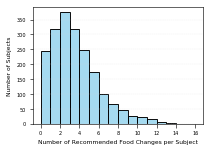

Median number of food changes: 3.0


In [39]:
steps = results_df["steps_taken"].dropna()

sns.histplot(steps, bins=range(int(steps.min()), int(steps.max())+2), 
             color="skyblue", edgecolor="black")

plt.xlabel("Number of Recommended Food Changes per Subject", labelpad=4)
plt.ylabel("Number of Subjects", labelpad=4)
# plt.title("Distribution of Recommended Food Changes")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

if save:
    plt.savefig(f"{figures_path}/{PHENOTYPE}/number_of_recommendations_hist_nm.pdf", dpi=600, bbox_inches="tight")   # for Nature Medicine
    plt.savefig(f"{figures_path}/{PHENOTYPE}/number_of_recommendations_hist_presentation.png", dpi=600, bbox_inches="tight")  # for slides

plt.show()

steps = results_df["steps_taken"].dropna()
median_steps = statistics.median(steps.tolist())
print(f"Median number of food changes: {median_steps}")

Median number of food changes: 3.0


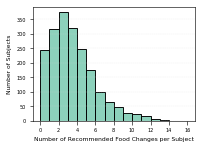

In [18]:
steps = results_df["steps_taken"].dropna()

# ---- Calculate median ----
median_steps = results_df["steps_taken"].median()
print(f"Median number of food changes: {median_steps}")

# ---- Apply Nature style ----
plt.style.use(single_style)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

# ---- Use Set2[0] green ----
color = sns.color_palette("Set2")[0]

# ---- Histogram ----
sns.histplot(
    steps,
    bins=range(int(steps.min()), int(steps.max())+2),
    color=color,
    edgecolor="black",
    ax=ax
)

# ---- Axis labels and formatting ----
ax.set_xlabel("Number of Recommended Food Changes per Subject", labelpad=4)
ax.set_ylabel("Number of Subjects", labelpad=4)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# ---- Legend (optional reference line) ----
# Example if you wanted to highlight 0:
# ax.axvline(0, color="black", linestyle="--", label="No Changes")
# ax.legend(frameon=True)

if save:
    fig.savefig(f"{figures_path}/{PHENOTYPE}/number_of_recommendations_hist_nm.pdf",
                dpi=400, bbox_inches="tight")
    fig.savefig(f"{figures_path}/{PHENOTYPE}/number_of_recommendations_hist_presentation.png",
                dpi=400, bbox_inches="tight")

plt.show()
plt.close(fig)

Convert results_df into a plotting format

In [19]:
def format_all_diet_comparison_tables(results_df):
    records = []

    for _, row in results_df.iterrows():
        # skip if no steps taken
        if row.get("steps_taken", 0) == 0:
            continue

        subject_id       = row["subject_id"]
        orig_pct         = row["original_diet"]
        final_pct        = row["recommended_diet"]
        total_change     = row["total_diet_change"]
        subject_calories = row["Energy"]

        # filter to foods that actually changed
        changed_foods = total_change[total_change != 0].index

        if changed_foods.empty:
            continue

        # restrict everything to changed foods
        orig_pct_food  = orig_pct[changed_foods]
        final_pct_food = final_pct[changed_foods]

        # convert to kcal
        orig_kcal  = orig_pct_food * subject_calories
        final_kcal = final_pct_food * subject_calories
        delta_kcal = final_kcal - orig_kcal

        # actual % change vs baseline (avoids forced -100%)
        pct_change_vs_food = (delta_kcal / orig_kcal) * 100

        for food in changed_foods:
            records.append({
                "Subject": subject_id,
                "Food": food,
                "Current Diet (kcal)": orig_kcal[food],
                "Recommended Change (kcal)": delta_kcal[food],
                "New Diet (kcal)": final_kcal[food],
                "Change vs Food Baseline (%)": pct_change_vs_food[food]
            })

    return pd.DataFrame(records)

all_recommendations = format_all_diet_comparison_tables(results_df)
all_recommendations

,Subject,Food,Current Diet (kcal),Recommended Change (kcal),New Diet (kcal),Change vs Food Baseline (%)
0,1,Tahini,109.380795,62.522562,171.903357,57.160457
1,2,Chicken,57.033405,-57.033405,0.000000,-100.000000
2,3,Banana,34.528500,34.400158,68.928658,99.628302
3,3,Beef,31.589516,-31.589516,0.000000,-100.000000
4,4,Apple,19.382776,19.235010,38.617786,99.237643
...,...,...,...,...,...,...
6044,1960,Wine,32.399395,-32.399395,0.000000,-100.000000
6045,1961,Apple,6.638622,6.895105,13.533727,103.863498
6046,1961,Chicken legs,16.018551,-16.018551,0.000000,-100.000000
6047,1961,Date honey,5.227283,5.429239,10.656523,103.863498


Summary statistics increases Vs. decreases

In [20]:
# Count how many foods were decreased vs increased
negative_changes = (all_recommendations["Change vs Food Baseline (%)"] < 0).sum()
positive_changes = (all_recommendations["Change vs Food Baseline (%)"] > 0).sum()
zero_changes     = (all_recommendations["Change vs Food Baseline (%)"] == 0).sum()

counts = {
    "Negative Changes": negative_changes,
    "Positive Changes": positive_changes,
    "Zero Changes": zero_changes
}

# compute percentages out of all non-zero changes
total_changes = negative_changes + positive_changes
if total_changes > 0:
    counts["Negative %"] = round(negative_changes / total_changes * 100, 1)
    counts["Positive %"] = round(positive_changes / total_changes * 100, 1)
else:
    counts["Negative %"] = counts["Positive %"] = 0.0
print(counts)

{'Negative Changes': 4263, 'Positive Changes': 1786, 'Zero Changes': 0, 'Negative %': 70.5, 'Positive %': 29.5}


In [21]:
diet_mb_test = pd.read_pickle(home_path + f"data/{SPECIES}/diet_mb_baseline_test.pkl")
test_subjects = diet_mb_test.index
diet_mb = diet_mb.loc[test_subjects, :]
foods = diet_mb[food_shortnames]
eaten_foods = (foods > 0).sum()

bacteria = diet_mb[targets]
existing_bacteria = (bacteria != -4).sum()
existing_bacteria_df = existing_bacteria.reset_index()
existing_bacteria_df.columns = ["Species", "count"]
existing_bacteria_df = rename_microbiome_df(existing_bacteria_df, mb_names)
existing_bacteria_df

,Species,count
0,Duodenibacillus intestinigallinarum,202
1,Duodenibacillus intestinavium,176
2,Duodenibacillus massiliensis,453
3,Sutterella wadsworthensis,1126
4,Sutterella sp937923675,213
...,...,...
719,Duodenibacillus sp900544335,123
720,Aphodousia faecalis,153
721,Parasutterella gallistercoris,146
722,Parasutterella excrementihominis,1119


### Plot histogram for all foods

With % from the food eaters

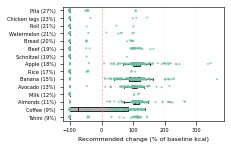

In [24]:
if not all_recommendations.empty:
    # --- Frequency-based box/strip plot ---
    food_counts = all_recommendations['Food'].value_counts()
    top_foods = food_counts.head(15).index.tolist()
    food_change_df_top = all_recommendations[
        all_recommendations['Food'].isin(top_foods)
    ].copy()

    # Compute percentage for each top food
    percent_data = []
    for food in top_foods:
        count = food_counts[food]
        total_eaters = eaten_foods.get(food, 0)
        percent = 100 * count / total_eaters if total_eaters > 0 else 0
        percent_data.append({"Food": food, "Percent": percent})

    percent_df = pd.DataFrame(percent_data).sort_values("Percent", ascending=False)

    # Build mapping with % only
    food_name_mapping = {
        row["Food"]: f"{row['Food']} ({row['Percent']:.0f}%)"
        for _, row in percent_df.iterrows()
    }

    # Apply mapping
    food_change_df_top["Food_Label"] = food_change_df_top["Food"].map(food_name_mapping)
    ordered_labels = [food_name_mapping[food] for food in percent_df["Food"]]

    # ---- Apply Nature style + create figure ----
    plt.style.use(single_style)
    fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

    # ---- Pull specific colors from Set2 ----
    set2 = sns.color_palette("Set2")
    strip_color = set2[0]   # teal (for points)
    box_gray   = set2[7]    # gray (for boxes)
    red_line   = set2[1]    # orange/red (for zero line)

    # ---- Boxplot (gray from Set2) ----
    sns.boxplot(
        data=food_change_df_top,
        y="Food_Label",
        x="Change vs Food Baseline (%)",
        order=ordered_labels,
        width=0.5,
        showcaps=True,
        boxprops={'facecolor': box_gray, 'edgecolor': 'black'},
        medianprops={'color': 'black'},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'},
        fliersize=0,
        ax=ax
    )

    # ---- Stripplot (teal from Set2) ----
    sns.stripplot(
        data=food_change_df_top,
        y="Food_Label",
        x="Change vs Food Baseline (%)",
        order=ordered_labels,
        size=2,       # same as microbial plot
        jitter=True,
        alpha=0.8,
        color=strip_color,
        ax=ax
    )

    # ---- Axis labels and formatting ----
    ax.set_xlabel("Recommended change (% of baseline kcal)")
    ax.axvline(x=0, linestyle='--', color=red_line, alpha=0.6)
    ax.set_ylabel("")
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    if save:
        fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_food_changes_nm.pdf",
                    dpi=400, bbox_inches="tight")
        fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_food_changes_presentation.png",
                    dpi=400, bbox_inches="tight")

    plt.show()
    plt.close(fig)

else:
    print("No recommended food changes found. Nothing to plot.")

### Plot individual food changes

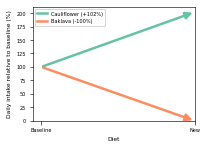

In [26]:
def plot_subject_recommendation_options(subject_df, subj_id, n_foods_to_show=10):
    # --- Apply Nature Medicine style ---
    plt.style.use(single_style)

    changed = subject_df.copy()

    # Sort by absolute % change
    top_sorted = changed.sort_values(
        by="Change vs Food Baseline (%)",
        key=abs, ascending=False
    ).head(n_foods_to_show)

    # --- Create figure with style-defined size ---
    fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

    x_pos = [0, 1]

    # --- Define color palette once ---
    palette = sns.color_palette("Set2", n_colors=len(top_sorted))
    colors = iter(palette)

    for _, row in top_sorted.iterrows():
        color = next(colors)
        food = row["Food"]

        # Baseline always 100%
        y_start = 100
        # New diet = 100% + change
        y_end = 100 + row["Change vs Food Baseline (%)"]

        delta_str = f"{row['Change vs Food Baseline (%)']:+.0f}%"
        label = f"{food} ({delta_str})"

        # Arrow
        ax.annotate(
            "",
            xy=(x_pos[1], y_end),
            xytext=(x_pos[0], y_start),
            arrowprops=dict(
                arrowstyle="-|>",
                color=color,
                lw=2.5,
                mutation_scale=14
            ),
        )
        # Dummy line for legend
        ax.plot([], [], color=color, label=label, lw=2.5)

    # --- Y-axis limits ---
    ymin = min(100, (100 + top_sorted["Change vs Food Baseline (%)"]).min())
    ymax = max(100, (100 + top_sorted["Change vs Food Baseline (%)"]).max())
    if ymin == ymax:
        ymin -= 5
        ymax += 5
    ax.set_ylim(ymin * 0.95, ymax * 1.05)

    # --- Axes setup ---
    ax.set_xticks(x_pos, labels=["Baseline", "New"])
    ax.set_ylabel("Daily intake relative to baseline (%)")
    ax.set_xlabel("Diet")

    # --- Legend (consistent fontsize from rcParams) ---
    ax.legend(
        loc="upper left",
        frameon=True,
        fontsize=plt.rcParams["legend.fontsize"]
    )

    if save:
        fig.savefig(
            f"{figures_path}/{PHENOTYPE}/subject{subj_id}_food_changes_nm.pdf",
            dpi=400, bbox_inches="tight"
        )
        fig.savefig(
            f"{figures_path}/{PHENOTYPE}/subject{subj_id}_food_changes_presentation.png",
            dpi=400, bbox_inches="tight"
        )

    plt.show()
    plt.close(fig)


# Example run
for subj_id in range(individual_example_index, individual_example_index+1):
    subj_df = all_recommendations[all_recommendations["Subject"] == subj_id]
    if not subj_df.empty:
        plot_subject_recommendation_options(subj_df, subj_id)

### Plot bacterial shifts

In [27]:
def build_microbiome_shift_table(result_row, subject_id=0):

    # Extract baseline and final microbiomes
    baseline_lin = result_row["predicted_baseline_microbiome"]
    final_lin = result_row["final_microbiome"]

    if isinstance(baseline_lin, pd.DataFrame):
        baseline_lin = baseline_lin.iloc[0]
    if isinstance(final_lin, pd.DataFrame):
        final_lin = final_lin.iloc[0]

    # Keep only microbial species (exclude demographics)
    species_cols = [c for c in final_lin.index if c not in ("age", "sex")]

    # Subset
    baseline_lin = baseline_lin[species_cols]
    final_lin = final_lin[species_cols]

    # Compute fold change (baseline 0 handled as NaN)
    fold_change = final_lin / baseline_lin.replace(0, np.nan)

    out_df = pd.DataFrame({
        "Species": species_cols,
        "Baseline Abundance": baseline_lin.values,
        "Predicted Fold Change": fold_change.values,
        "Predicted Abundance": final_lin.values,
        "Subject": subject_id
    })

    return out_df.reset_index(drop=True)

all_dfs = []
for _, row in results_df.iterrows():
    subj_df = build_microbiome_shift_table(
        row,
        subject_id=row["subject_id"]
    )
    all_dfs.append(subj_df)

# concatenate them all into one
microbial_df_raw = pd.concat(all_dfs, ignore_index=True)

# now sort if you like
microbial_df_raw = microbial_df_raw.sort_values(
    by="Predicted Fold Change", ascending=False
).reset_index(drop=True)

microbial_df = rename_microbiome_df(microbial_df_raw, mb_names)
microbial_df[microbial_df['Species'] == 'Faecalibacterium longum_1']
existant_mask = microbial_df['Baseline Abundance'] != 0.0001
microbial_df = microbial_df[existant_mask]

microbial_df

,Species,Baseline Abundance,Predicted Fold Change,Predicted Abundance,Subject
0,Streptococcus thermophilus,0.002039,1.485850,0.003030,468
1,UBA11774 sp003507655,0.001805,1.473955,0.002660,1410
2,Streptococcus thermophilus,0.001694,1.420223,0.002406,313
3,Streptococcus thermophilus,0.000908,1.413139,0.001283,80
4,UBA11524 sp000437595,0.007139,1.395626,0.009964,887
...,...,...,...,...,...
1420483,Bifidobacterium longum,0.004291,0.588090,0.002523,1361
1420484,Streptococcus thermophilus,0.001736,0.564877,0.000981,1601
1420485,Bifidobacterium longum,0.004437,0.532618,0.002363,1508
1420486,Bifidobacterium adolescentis,0.005308,0.514857,0.002733,87


Among all subjects who had each bacteria at baseline, 
what % were recommended a change greater than 0.5%.

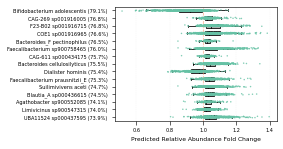

In [30]:
if not microbial_df.empty:

    tol = 0.005  # 0.5% tolerance
    min_subjects = 20   # require at least this many baseline carriers
    top_n = 15    # how many species to plot

    filtered_df = microbial_df.copy()

    # ---- Apply tolerance filter ----
    filtered_changed = filtered_df[
        (filtered_df["Predicted Fold Change"] > 1 + tol) |
        (filtered_df["Predicted Fold Change"] < 1 - tol)
    ].copy()

    # ---- Numerator: # of subjects with meaningful change per species ----
    species_counts = (
        filtered_changed.groupby("Species")["Subject"]
        .nunique()
        .rename("recommended")
    )

    # ---- Denominator: baseline carriers ----
    baseline_counts = (
        existing_bacteria_df.set_index("Species")["count"]
        .rename("baseline_subjects")
    )

    merged_counts = pd.concat([species_counts, baseline_counts], axis=1).fillna(0)
    merged_counts["normalized"] = (
        merged_counts["recommended"] / merged_counts["baseline_subjects"]
    )

    # ---- Apply prevalence filter ----
    merged_counts = merged_counts[
        merged_counts["baseline_subjects"] >= min_subjects
    ]

    # ---- Select top N ----
    top_species = merged_counts.sort_values("normalized", ascending=False).head(top_n)

    # ---- Labels with % ----
    label_map = {
        sp: f"{sp} ({row['normalized']:.1%})"
        for sp, row in top_species.iterrows()
    }

    filtered_changed['Species_Label'] = filtered_changed['Species'].map(label_map)
    ordered_labels = list(label_map.values())

    # ---- Apply Nature style + create figure ----
    plt.style.use(single_style)
    fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

    # ---- Pull specific colors from Set2 ----
    set2 = sns.color_palette("Set2")
    strip_color = set2[0]   # teal
    box_gray   = set2[7]    # gray
    red_line   = set2[1]    # orange/red

    # ---- Boxplot (gray from Set2) ----
    sns.boxplot(
        data=filtered_changed[filtered_changed['Species'].isin(top_species.index)],
        y="Species_Label",
        x="Predicted Fold Change",
        order=ordered_labels,
        width=0.5,
        showcaps=True,
        boxprops={'facecolor': box_gray, 'edgecolor': 'black'},
        medianprops={'color': 'black'},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'},
        fliersize=0,
        ax=ax
    )

    # ---- Stripplot (teal from Set2) ----
    sns.stripplot(
        data=filtered_changed[filtered_changed['Species'].isin(top_species.index)],
        y="Species_Label",
        x="Predicted Fold Change",
        order=ordered_labels,
        size=1.5,
        jitter=True,
        alpha=0.8,
        color=strip_color,
        ax=ax
    )

    # ---- Axis labels and formatting ----
    ax.set_xlabel("Predicted Relative Abundance Fold Change")
    ax.axvline(x=1, linestyle='--', color=red_line, alpha=0.6)
    ax.set_ylabel("")
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    if save:
        fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_microbial_changes_nm.pdf",
                    dpi=400, bbox_inches="tight")
        fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_microbial_changes_presentation.png",
                    dpi=400, bbox_inches="tight")

    plt.show()
    plt.close(fig)

else:
    print("No microbial predictions found. Nothing to plot.")

### Plot individual microbiome chanegs

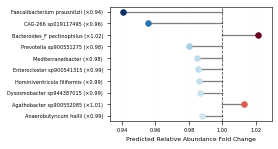

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

def plot_subject_microbiome_shift(microbial_df, subj_id, n_species_to_show=10, min_baseline=0.00011):
    subj_species = microbial_df[microbial_df['Subject'] == subj_id].copy()
    if subj_species.empty:
        print(f"No microbial shift data for subject {subj_id}")
        return

    # ---- Filter out very rare species ----
    subj_species = subj_species[subj_species['Baseline Abundance'] > min_baseline]

    # ---- Compute fold change ----
    subj_species["Fold Change"] = subj_species["Predicted Abundance"] / subj_species["Baseline Abundance"]

    # ---- Distance from no change (×1) for ranking ----
    subj_species["AbsFoldDiff"] = (subj_species["Fold Change"] - 1).abs()

    # ---- Sort by absolute fold change ----
    subj_species = (
        subj_species.sort_values(by="AbsFoldDiff", ascending=False)
        .head(n_species_to_show)
        .reset_index(drop=True)
    )

    # ---- Reverse the order for plotting (so biggest on top) ----
    subj_species = subj_species.iloc[::-1].reset_index(drop=True)

    # ---- Apply Nature style ----
    plt.style.use(single_style)
    fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

    # ---- Continuous colormap centered at 1 ----
    vmin = subj_species["Fold Change"].min()
    vmax = subj_species["Fold Change"].max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
    cmap = cm.get_cmap("RdBu_r")   # you can also try "vlag" or "coolwarm"

    # ---- Plot lines + points ----
    for i, row in subj_species.iterrows():
        # connector line (neutral gray)
        ax.plot([1, row["Fold Change"]], [i, i], color="gray", lw=1.3)

        # point colored by fold change
        dot_color = cmap(norm(row["Fold Change"]))
        ax.scatter(row["Fold Change"], i, color=dot_color, s=30, zorder=3)

    # ---- Y-axis labels with fold change ----
    species_labels = [
        f"{row['Species']} (×{row['Fold Change']:.2f})"
        for _, row in subj_species.iterrows()
    ]
    ax.set_yticks(range(len(species_labels)))
    ax.set_yticklabels(species_labels)

    # ---- Vertical reference line ----
    ax.axvline(1, linestyle="--", color="black", alpha=0.7)

    # ---- Axis formatting ----
    ax.set_xlabel("Predicted Relative Abundance Fold Change", labelpad=4)
    ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    # ---- Auto x-limits with small padding ----
    fc_min = subj_species["Fold Change"].min()
    fc_max = subj_species["Fold Change"].max()
    padding = (fc_max - fc_min) * 0.1 if fc_max > fc_min else 0.05
    ax.set_xlim(fc_min - padding, fc_max + padding)

    if save:
        fig.savefig(f"{figures_path}/{PHENOTYPE}/subject{subj_id}_microbial_changes_nm.pdf",
                    dpi=400, bbox_inches="tight")
        fig.savefig(f"{figures_path}/{PHENOTYPE}/subject{subj_id}_microbial_changes_presentation.png",
                    dpi=400, bbox_inches="tight")

    plt.show()
    plt.close(fig)

# Example run
for subj_id in range(individual_example_index, individual_example_index+1):
    plot_subject_microbiome_shift(microbial_df, subj_id)


### Plot triglycerides reductions

With a person-specific arrow

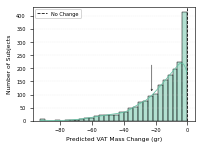

In [41]:
# ---- Compute change ----
diff = pd.Series(results_df['final_tg'] - results_df['original_tg'])

# ---- Subject to highlight ----
subj_change = diff.loc[individual_example_index]

# ---- Apply Nature style ----
plt.style.use(single_style)
fig, ax = plt.subplots(figsize=plt.rcParams["figure.figsize"])

# ---- Colors ----
main_color = sns.color_palette("Set2")[0]      # green for histogram
highlight_color = sns.color_palette("Set2")[1] # orange for subject highlight

# ---- Label based on phenotype ----
if PHENOTYPE == 'Triglycerides':
    xlabel = 'Predicted Triglycerides Change (mg/dL)'
elif PHENOTYPE == 'Vat':
    xlabel = 'Predicted VAT Mass Change (gr)'
elif PHENOTYPE == 'WBC':
    xlabel = 'Predicted WBC Count Change (×10⁹ cells/L)'
elif PHENOTYPE == 'Ultrasound':
    xlabel = "Predicted Liver Sound Speed Change (m/s)"
else:
    xlabel = 'Change'

# ---- Histogram ----
sns.histplot(diff, bins=30, kde=True, color=main_color, ax=ax)
ax.axvline(0, color='black', linestyle='--', label='No Change')

# ---- Dashed arrow spanning full y-range ----
ymin, ymax = ax.get_ylim()
# ---- Dashed arrow with manual y-coordinates ----





if PHENOTYPE == 'Triglycerides':
    ax.annotate("",
                xy=(subj_change, 145),        # arrow tip at x-axis
                xytext=(subj_change, 280),  # start at y=150 (manual)
                arrowprops=dict(arrowstyle="->",
                                mutation_scale=4,
                                color='black',
                                linestyle="-",
                                lw=0.5), label=f"Subject {individual_example_index}")
    

elif PHENOTYPE == 'Vat':
    ax.annotate("",
                xy=(subj_change, 105),        # arrow tip at x-axis
                xytext=(subj_change, 220),  # start at y=150 (manual)
                arrowprops=dict(arrowstyle="->",
                                mutation_scale=4,
                                color='black',
                                linestyle="-",
                                lw=0.5), label=f"Subject {individual_example_index}")

elif PHENOTYPE == 'WBC':
    ax.annotate("",
            xy=(subj_change, 227),        # arrow tip at x-axis
            xytext=(subj_change, 340),  # start at y=150 (manual)
            arrowprops=dict(arrowstyle="->",
                            mutation_scale=4,
                            color='black',
                            linestyle="-",
                            lw=0.5), label=f"Subject {individual_example_index}")

# ---- Axis labels and formatting ----
ax.set_xlabel(xlabel, labelpad=4)
ax.set_ylabel('Number of Subjects', labelpad=4)
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(frameon=True)

if save:
    fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_improvements_nm.pdf",
                dpi=400, bbox_inches="tight")
    fig.savefig(f"{figures_path}/{PHENOTYPE}/overall_improvements_presentation.png",
                dpi=400, bbox_inches="tight")

plt.show()
plt.close(fig)

Specific value for the representative individual

In [37]:
diff[individual_example_index]

-22.381836